In [1]:
using RxInfer
using Distributions
using GraphViz

In [ ]:
struct EmissionNode{T <: Real} <: DiscreteUnivariateDistribution
    x :: T
end

@node EmissionNode Stochastic [out, x]

# #rules towards out NOT NEEDED
# @rule EmissionNode(:out, Marginalisation) (q_x :: Bernoulli,) = begin
#     println("towards out ", mean(q_x))
#     PointMass(mean(q_x))
# end

#rules towards x
@rule EmissionNode(:x, Marginalisation) (q_out :: PointMass,) = begin
    # NB! We normalise the emission probs.
    tmpx0 = pdf(Normal(0,1), q_out.point) # note for pointmass v(x)∝exp⁡∫q(π)ln⁡Ber(x∣π)dx = Ber(x∣π)
    tmpx1 = pdf(Normal(0,1), q_out.point-1)
    p = tmpx1/(tmpx0+tmpx1)
    println("q_out during towards x ", q_out.point)
    return Bernoulli(p)
end


@marginalrule EmissionNode(:out_x) (q_out::PointMass, q_x::Bernoulli) = begin
    tmpn0 = pdf(Normal(0,1), q_out.point) # note for pointmass v(x)∝exp⁡∫q(π)ln⁡Ber(x∣π)dx = Ber(x∣π)
    tmpn1 = pdf(Normal(0,1), q_out.point-1)
    println("q_out marginal ", q_out.point)
    tmpp1 = q_x.p
    tmpp0 = 1-tmpp1
    
    Z = tmpn0*tmpp0 + tmpn1 * tmpp1
    p = tmpn1 * tmpp1 / Z

    return (out = q_out, x = Bernoulli(p))
end

@average_energy EmissionNode (q_out::PointMass, q_x::Bernoulli) = - 1/2 * log(2 * π) - q_x.p/2 * (q_out.point-1)^2 - (1-q_x.p)/2*q_out.point^2

In [3]:
@model function my_model(y1, y2)
    x ~ Bernoulli(0.75)
    y1 ~ EmissionNode(x)
    y2 ~ EmissionNode(x)
end
# constraints = @constraints begin
#     q(p, x) = q(p)q(x)
# end

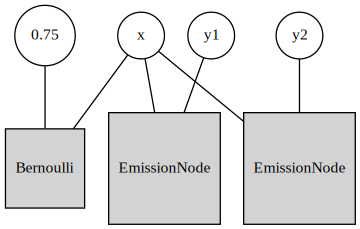

In [4]:
using GraphViz

model_generator = my_model() | (y1 = 1.0, y2 = 1.5)
model_to_plot = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple, layout="dot", width=5.,height=5.)

In [5]:
a = infer(
    model = my_model(),
    # constraints = hidden_markov_constraints,
    data = (y1 = 1.0, y2=1.5),
    options = (limit_stack_depth = 500,),
    free_energy = true,
    showprogress=true,
    iterations = 2,    
    callbacks = (
        on_marginal_update = (model, name, update) -> println("$(name) has been updated: $(update)"),
    )
)

q_out during towards x 1.0
q_out during towards x 1.5
x has been updated: Marginal(Bernoulli{Float64}(p=0.930772215498069))
q_out during towards x 1.0
q_out during towards x 1.5
x has been updated: Marginal(Bernoulli{Float64}(p=0.930772215498069))


Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[-1.95462, -1.95462]


In [6]:
a.posteriors[:x]

2-element Vector{Bernoulli{Float64}}:
 Bernoulli{Float64}(p=0.930772215498069)
 Bernoulli{Float64}(p=0.930772215498069)

In [7]:
x = 3; println(String("Hello, $(x)!"))

Hello, 3!
